In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt
from scipy.stats import gamma, uniform
import seaborn as sns
import os
from statsmodels.tsa.stattools import acf

plt.style.use('seaborn')


# Methods for exporting tables and images to latex
def saveimg(filename, fig):
    file_path = os.path.join(os.getcwd(), 'images')
    os.makedirs(file_path, exist_ok=True)
    fig.savefig(os.path.join(file_path, filename))
    
def savetable(filename, df):
    file_path = os.path.join(os.getcwd(), 'tables')
    os.makedirs(file_path, exist_ok=True)
    pd.DataFrame(df).to_latex(os.path.join(file_path, filename),escape = False, index = False)

# Methods used in exercise

In [3]:
# Importing files
disasters = genfromtxt('disasters.csv', delimiter = ',')

# Calculate transition probability, based on random walk proposal
def calc_probability_random_walk(tau, breakpoints_current, breakpoints_propose, labda):
    
    # Check if sorted, otherwise return 0
    if np.all(breakpoints_propose[:-1] <= breakpoints_propose[1:]):
        
        # Calculate number of disasters per intervall
        nt_current = np.histogram(tau, bins = breakpoints_current)[0].astype('int32')
        nt_propose = np.histogram(tau, bins = breakpoints_propose)[0].astype('int32')
        
        # Calculate probabilty for current t
        log_prob_current = (np.sum(np.log(np.diff(breakpoints_current)))
                              - np.sum(labda*np.diff(breakpoints_current)) 
                            + np.sum(nt_current*np.log(labda)))
        
        # Caluclate probability for proposal
        log_prob_propose = (np.sum(np.log(np.diff(breakpoints_propose)))
                            -np.sum(labda*np.diff(breakpoints_propose)) 
                            + np.sum(nt_propose*np.log(labda)))
        
        return np.minimum(1, np.exp(log_prob_propose - log_prob_current))
    
    else:
        return 0 
    
# Propose moving one single breakpoint
def proposal_random_walk(breakpoints, index, rho):
    
    ti = breakpoints[index]
    
    R = rho*(breakpoints[index+1] - breakpoints[index-1])
    epsilon = np.random.uniform(-R, R)
    ti_proposal = ti + epsilon
    
    new_breakpoints = breakpoints.copy()
    new_breakpoints[index] = ti_proposal
    
    return new_breakpoints

# Sample conditional lambda based on marginal posterior
def sample_lambdas(tau, theta, breakpoints, num_breakpoints):
    
    nt_current = np.histogram(tau, bins = breakpoints)[0].astype('int32')
    diff = np.diff(breakpoints)
    
    sample_lambda = lambda i: np.random.gamma(2 + nt_current[i], 1/(theta + diff[i]))
    
    lambdas = np.apply_along_axis(sample_lambda, 0, np.arange(0, num_breakpoints + 1))
    
    return lambdas

# Sample conditional theta based on marginal posterior
def sample_theta(psi, labdas, num_breakpoints):
    
    theta = np.random.gamma(2 + 2*(num_breakpoints + 1), 1/(psi + np.sum(labdas)))
    
    return theta
    
    
def init_mcmc(N, num_breakpoints, psi, rho, burn_in = 0):
    
    # Initial burn in attempts if needed
    M = N + burn_in
    
    # Initialize arrays
    breakpoints = np.zeros((M, num_breakpoints + 2))
    breakpoints[0] = np.arange(1658,1981, (1980-1658)/(num_breakpoints+1))
    tau = disasters  

    # Arrays to save values of lambda and theta
    lambdas = np.zeros((M, num_breakpoints + 1))
    thetas = np.zeros(M)
    
    # Array to save MH probability
    probs = np.zeros((M,num_breakpoints))
    accepts = np.zeros((M,num_breakpoints))
    
    # Initialize theta and lambda by prior distribution
    thetas[0] = np.random.gamma(2, 1/psi)
    
    for interval in range(num_breakpoints + 1):
        lambdas[0, interval] = np.random.gamma(2, 1/thetas[0])
    
    # Main loop
    for index in range(M - 1):
        
        # Gibbs sampling
        thetas[index + 1] = sample_theta(psi, lambdas[index], num_breakpoints)
        lambdas[index + 1] = sample_lambdas(tau, thetas[index + 1], breakpoints[index], num_breakpoints)
        
        # Set new breakpoints equal to last ones
        breakpoints[index + 1] = breakpoints[index].copy()
        
        # Propose one breakpoint at a time
        for t in np.arange(num_breakpoints) + 1:
                                    
            # Propose new breakpoint
            new_breakpoints = proposal_random_walk(breakpoints[index + 1], t, rho)

            # Probability of accept
            probs[index, t - 1] = calc_probability_random_walk(tau, breakpoints[index + 1], new_breakpoints, lambdas[index + 1])
            accept = np.random.uniform(0,1) < probs[index, t - 1]
            
            if accept:
                # If accepted update to new breakpoint
                breakpoints[index + 1] = new_breakpoints
            
            accepts[index,t - 1] = accept

    return breakpoints[burn_in:], thetas[burn_in:], lambdas[burn_in:], probs[burn_in:], accepts[burn_in:]
    

# C) Trying different d

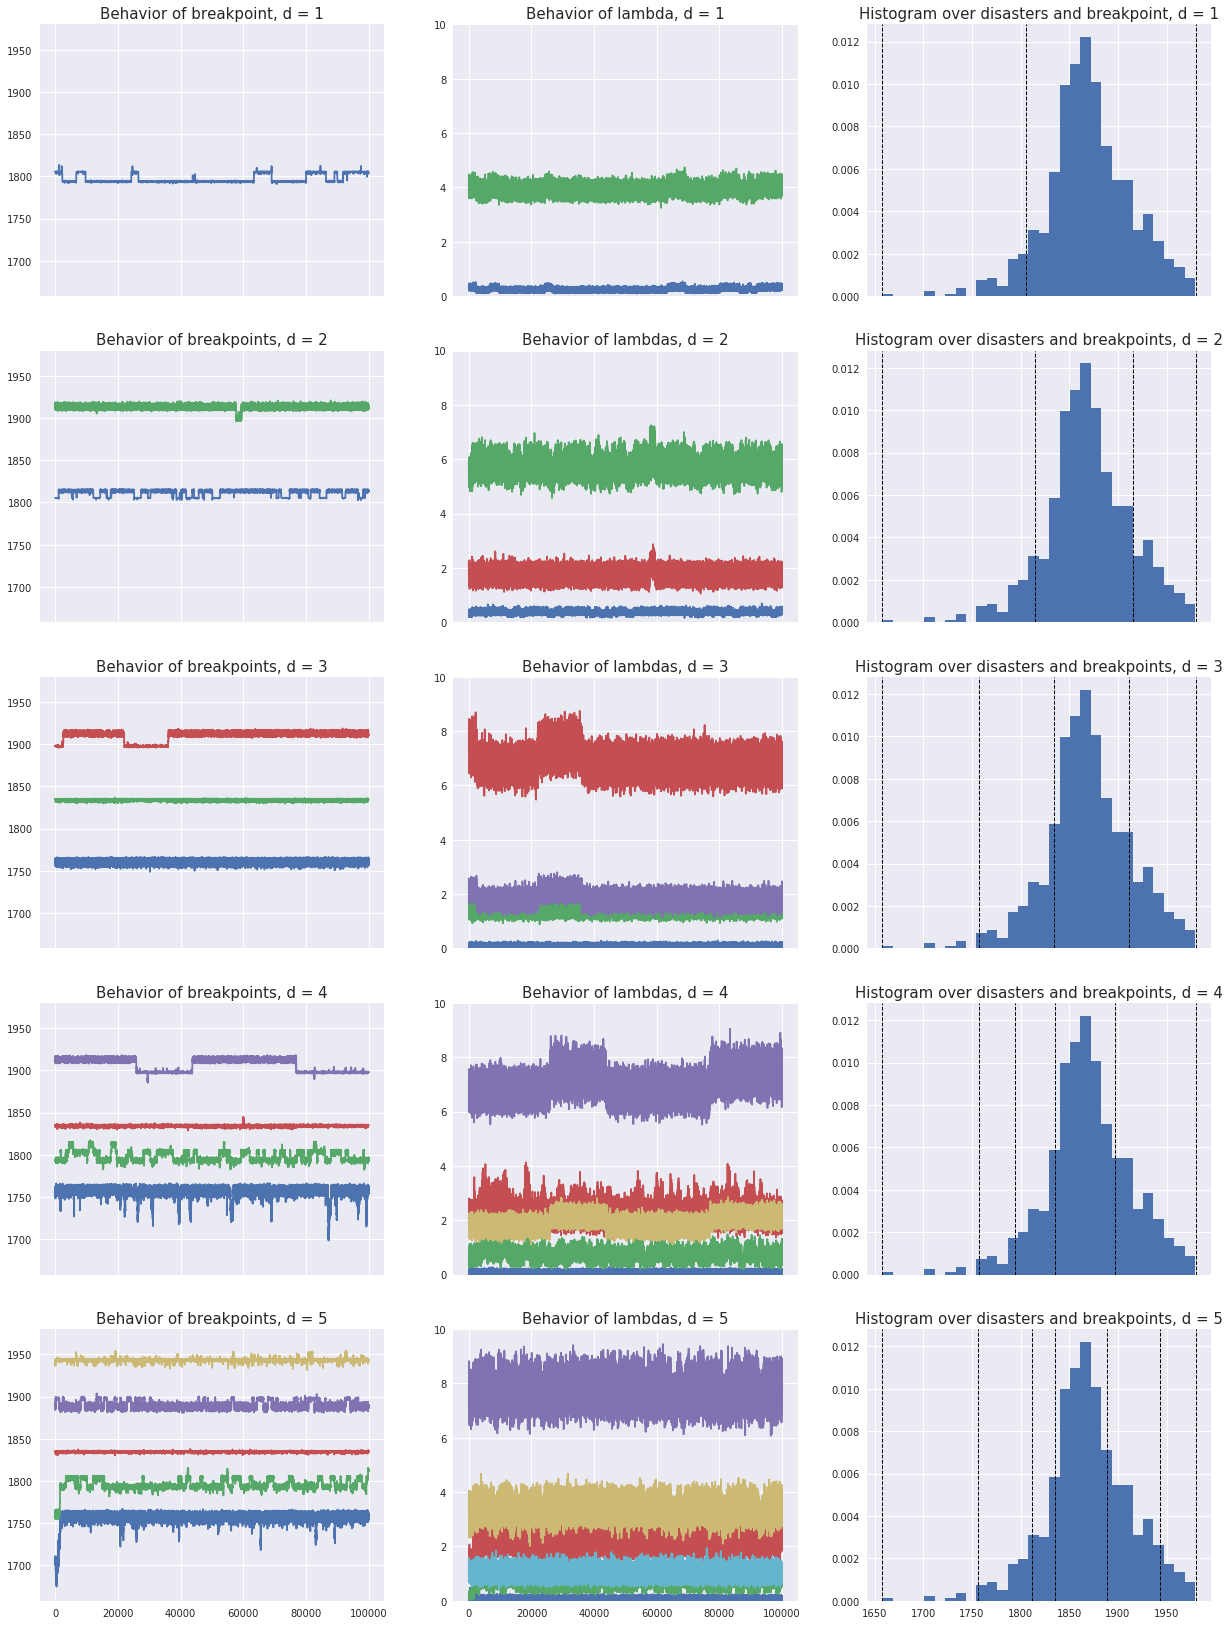

In [33]:
fig, axes = plt.subplots(5, 3, figsize = (21,29), sharex="col")

s = lambda n: "s" if (n > 1) else ""

axes[0, 0]._shared_x_axes.join(axes[0, 0], axes[1,0])
rates = np.zeros(5)

# Looping over d = 1 to 5 and creating plots
for n in np.arange(1,6):

    breakpoints, thetas, lambdas, probs, accepts = init_mcmc(N = 10**5, 
                                                            num_breakpoints = n, 
                                                            psi = 20, 
                                                            rho = 0.025,
                                                            burn_in = 10**3)

    rates[n - 1] = np.sum(accepts)/np.size(accepts)

    axes[n - 1, 0].plot(breakpoints[:, 1:-1])
    axes[n - 1, 0].set_title(f'Behavior of breakpoint{s(n)}, d = {n}', fontsize=15)
    axes[n - 1, 0].set_ylim([1658, 1980])

    axes[n - 1, 1].plot(lambdas)
    axes[n - 1, 1].set_title(f'Behavior of lambda{s(n)}, d = {n}', fontsize=15)
    axes[n - 1, 1].set_ylim([0, 10])


    axes[n - 1, 2].hist(disasters, bins = 'auto', density  = True)
    axes[n - 1, 2].set_title(f'Histogram over disasters and breakpoint{s(n)}, d = {n}', fontsize=15)

    for breakpoint in breakpoints[-1]:
        axes[n - 1, 2].axvline(breakpoint, color='k', linestyle='dashed', linewidth=1)

plt.savefig("images/chain_behavior.png")

In [34]:
# Generating table with acceptance rates
rates_dict = [{"Number of breakpoints" : "Acceptance rate", "d = 1" : rates[0], "d = 2" : rates[1], "d = 3" : rates[2], "d = 4" : rates[3], "d = 5" : rates[4]}]
df = pd.DataFrame(rates_dict)
savetable("acceptance_rates.tex", df)

# e) Testing different $\rho$ 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


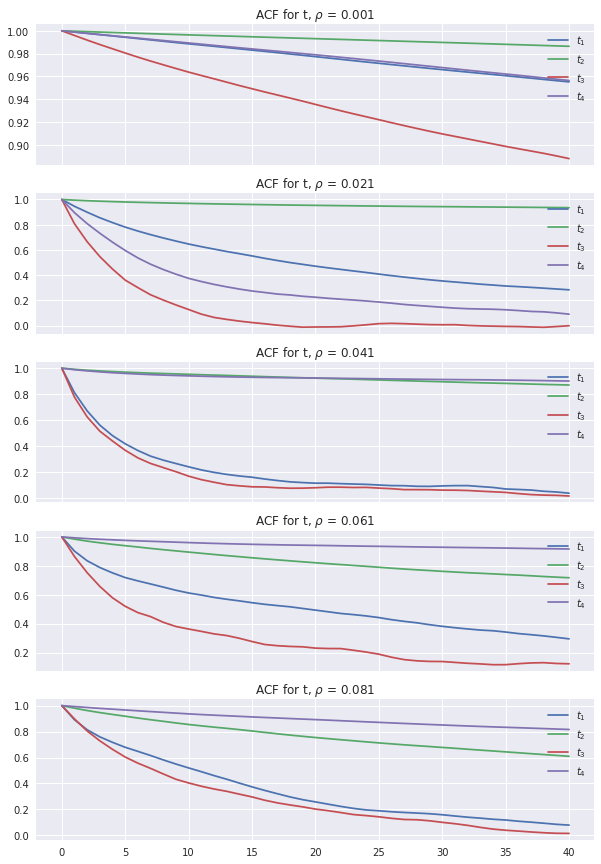

In [32]:
n = 100
rho_min = 0.001
rho_max = 0.1

psi = 20
num_breakpoints = 4

rhos = np.linspace(rho_min, rho_max, n)
acceptance = np.zeros(n)

fig, axes = plt.subplots(5, figsize = (10,15), sharex=True)

i = 0

for index in range(n):
    
    print(index)

    breakpoints, _, _, _, accepts = init_mcmc(N = 10**4, num_breakpoints = num_breakpoints, psi = psi, rho = rhos[index] , burn_in = 10**3)
    acceptance[index] = np.sum(accepts)/np.size(accepts)
    
    if(index % 20 == 0):
        t = 1
        for breakpoint in breakpoints.swapaxes(1,0)[1:-1]:
            axes[i].plot(np.arange(41), acf(breakpoint, fft=False), label=f'$t_{t}$')
            axes[i].set_title(fr'ACF for t, $\rho$ = {rhos[index]}')
            
            t+=1
            
        axes[i].legend(loc='upper right')
        i+= 1

plt.show() 
saveimg("ACF.png", fig)

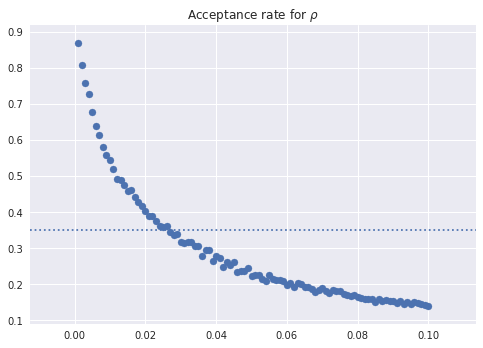

In [35]:
plt.scatter(rhos, acceptance)
plt.axhline(0.35, linestyle="dotted")
plt.title(r'Acceptance rate for $\rho$')
plt.savefig("images/accept_rho.png")

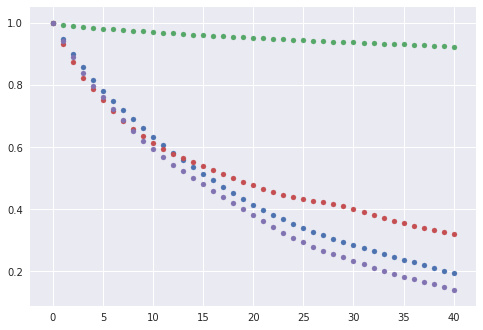

In [79]:
breakpoints.swapaxes(1,0)[1:-1]

array([[1734.54098923, 1735.39598681, 1735.39598681, ..., 1757.66699493,
        1758.20255189, 1758.32201025],
       [1793.9262356 , 1793.9262356 , 1793.9262356 , ..., 1794.99590972,
        1794.99590972, 1794.99590972],
       [1838.88462183, 1838.88462183, 1837.11540697, ..., 1835.31537758,
        1833.72592448, 1834.81744569],
       [1909.93457116, 1911.32527906, 1912.60446175, ..., 1910.38603693,
        1910.38603693, 1910.38603693]])

# d) Testing different $\Psi$

In [11]:
n = 50
psi_min = 1
psi_max = 50

num_breakpoints = 3

psis = np.linspace(psi_min, psi_max, n)

lambdas_mean = np.zeros((n, 4))
lambdas_var = np.zeros((n, 4))

thetas_mean = np.zeros(n)
thetas_var = np.zeros(n)

for index in range(n):
    
    _, theta, lambdas, _, _ = init_mcmc(N = 10**4, num_breakpoints = num_breakpoints, psi = psis[index], rho = 0.025 , burn_in = 10**2)
    
    thetas_mean[index] = np.mean(theta)
    thetas_var[index] = np.var(theta)

    lambdas_mean[index] = lambdas.mean(axis=0)
    lambdas_var[index] = lambdas.var(axis=0)


KeyboardInterrupt: 

In [ ]:
# Generate plots

fig, axes = plt.subplots(2, 2, sharex=True, figsize = (10,7))

axes[0, 0].scatter(psis, thetas_mean, s = 10)
axes[0, 1].scatter(psis, thetas_var, s = 10)

i = 1

for lamba in lambdas_mean.swapaxes(0,1):
    axes[1,0].scatter(psis, lamba, s = 10, label=f'$\lambda_{i}$ ')
    i+=1

i = 1
for lamba in lambdas_var.swapaxes(0,1):
    axes[1,1].scatter(psis, lamba, s = 10, label=f'$\lambda_{i}$ ')
    i+=1

axes[0, 0].set_title(r"Mean of $\theta$")
axes[0, 1].set_title(r"Variance of $\theta$")
axes[1, 0].set_title("Mean of $\lambda_i$")
axes[1, 1].set_title("Variance of $\lambda_i$")

axes[1, 1].legend()

saveimg("psi.png", fig)